# Score vs Pathwise Gradient

In [1]:
from blackbirds.models.sir import SIR
from blackbirds.infer import VI
from blackbirds.simulate import simulate_and_observe_model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import pygtc
import normflows as nf

In [2]:
n_agents = 1000
graph = networkx.watts_strogatz_graph(n_agents, 10, 0.1)
sir = SIR(graph, n_timesteps=100)

In [3]:
true_parameters = torch.tensor([0.05, 0.05, 0.05]).log10()
data = sir.observe(sir.run(true_parameters))

In [4]:
prior = torch.distributions.MultivariateNormal(-2.0 * torch.ones(3), torch.eye(3))

In [5]:
def setup_flow():
    K = 4
    torch.manual_seed(0)
    
    latent_size = 3
    hidden_units = 64
    hidden_layers = 2
    
    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]
    
    # Set prior and q0
    q0 = nf.distributions.DiagGaussian(3, trainable=False)
        
    # Construct flow model
    flow = nf.NormalizingFlow(q0=q0, flows=flows)
    return flow

class L2Loss:
    def __init__(self, model):
        self.model = model
        self.loss_fn = torch.nn.MSELoss()
    def __call__(self, params, data):
        observed_outputs = simulate_and_observe_model(self.model, params, gradient_horizon=0)
        return self.loss_fn(observed_outputs[0], data[0])

In [6]:
def train_estimator(gradient_estimation_mode, n_samples_per_epoch):
    torch.manual_seed(0)
    posterior_estimator = setup_flow() 
    optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-3)
    loss = L2Loss(sir)
    vi = VI(loss = loss, 
            posterior_estimator=posterior_estimator, 
            prior=prior, 
            data=data, 
            optimizer=optimizer,
            w = 10.0, 
            n_samples_per_epoch=n_samples_per_epoch,
            gradient_estimation_method=gradient_estimation_mode,
   )
    vi.run(250, max_epochs_without_improvement=250)
    return vi

In [7]:
%%time
vi_pathwise = train_estimator("pathwise", 5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:52<00:00,  1.41s/it, loss=1.47e+3, reg.=99.6, total=1.57e+3, best loss=491, epochs since improv.=55]

CPU times: user 5min 39s, sys: 2min 26s, total: 8min 5s
Wall time: 5min 52s


In [8]:
%%time
vi_score = train_estimator("score", 5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [03:07<00:00,  1.33it/s, loss=8.17e+4, reg.=187, total=8.19e+4, best loss=4.33e+4, epochs since improv.=111]

CPU times: user 2min 49s, sys: 2min 23s, total: 5min 13s
Wall time: 3min 7s


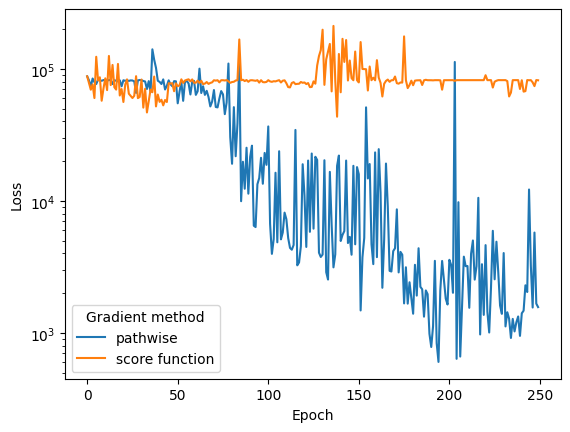

In [9]:
f, ax = plt.subplots()
ax.plot(vi_pathwise.losses_hist["total"], label = "pathwise")
ax.plot(vi_score.losses_hist["total"], label = "score function")
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend(title="Gradient method")

In [10]:
vi_pathwise.posterior_estimator.load_state_dict(vi_pathwise.best_estimator_state_dict)
vi_score.posterior_estimator.load_state_dict(vi_score.best_estimator_state_dict)

<All keys matched successfully>

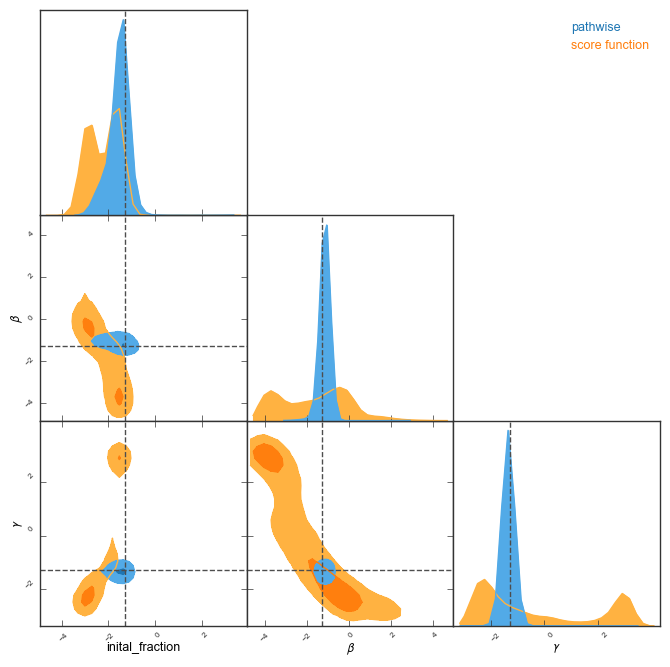

In [11]:
samples_pw = vi_pathwise.posterior_estimator.sample(10000)[0].detach().numpy()
samples_score = vi_score.posterior_estimator.sample(10000)[0].detach().numpy()

pygtc.plotGTC(chains=[samples_pw, samples_score],
              figureSize=8, 
              truths = true_parameters.numpy(), 
              chainLabels=["pathwise", "score function"], 
              paramNames=["inital_fraction", r"$\beta$", r"$\gamma$"]);

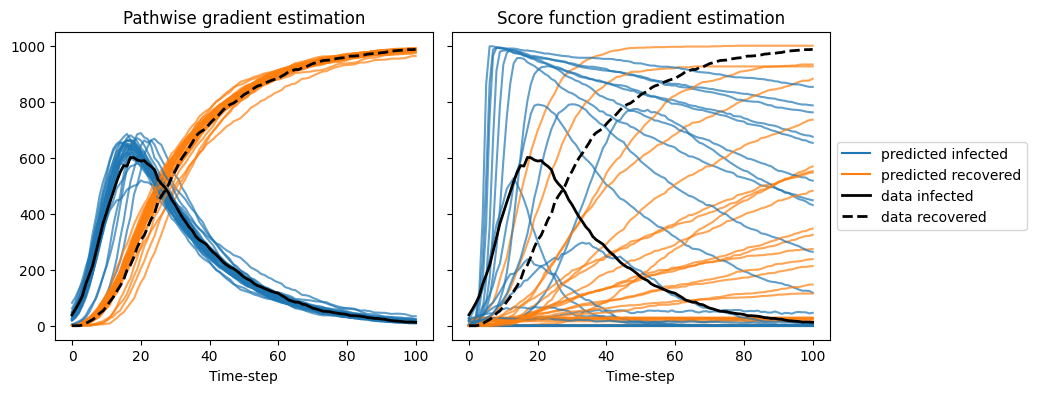

In [12]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
alpha=0.7

for i in range(25):
    with torch.no_grad():
        sim_sir_pw = sir.run_and_observe(vi_pathwise.posterior_estimator.sample(1)[0][0])
        ax[0].plot(sim_sir_pw[0].numpy(), color = "C0", alpha=alpha)
        ax[0].plot(sim_sir_pw[1].numpy(), color = "C1", alpha=alpha)
        sim_sir_score = sir.run_and_observe(vi_score.posterior_estimator.sample(1)[0][0])
        ax[1].plot(sim_sir_score[0].numpy(), color = "C0", alpha=alpha)
        ax[1].plot(sim_sir_score[1].numpy(), color = "C1", alpha=alpha)
    
ax[1].plot([], [], color = "C0", label = "predicted infected")
ax[1].plot([], [], color = "C1", label = "predicted recovered")
for i in range(2):
    ax[i].plot(data[0], color = "black", linewidth=2, label = "data infected")
    ax[i].plot(data[1], color = "black", linewidth=2, label = "data recovered", linestyle="--")
    ax[i].set_xlabel("Time-step")

ax[0].set_title("Pathwise gradient estimation")
ax[1].set_title("Score function gradient estimation")

ax[1].legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.subplots_adjust(wspace=0.05, hspace=0.05)